Arctic sea ice forecasting using deep neural networks.

A CNN models will be trained to predict the sea ice concentration (SIC, from 0 - 1) in the Barents Sea, with SIC and the change of ocean heat content (OHC) as inputs.

The model will be used for XAI analysis.

In [1]:
import numpy as np
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

Load and prepare data.

In [2]:
# path to processed data
path_data = Path("./data/")

In [3]:
# start and end time of the period of interest
start_year = 2000
end_year = 2017
# number of weeks per year (assuming each month contains 4 weeks)
nweeks = 48
# load preprocessed data - sea ice concentration
sic_xr = xr.load_dataset(path_data / "sic_erai_2000_2017.nc")
sic_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    sic        (year, week, latitude, longitude) float64 0.07345 ... -1.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly Sea Ice Concentration

In [4]:
# load preprocessed data - ocean heat content
ohc_xr = xr.load_dataset(path_data /  "ohc_oras_2000_2017.nc")
ohc_xr

<xarray.Dataset>
Dimensions:    (year: 18, week: 48, latitude: 24, longitude: 56)
Coordinates:
  * year       (year) int32 2000 2001 2002 2003 2004 ... 2014 2015 2016 2017
  * week       (week) int32 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
  * latitude   (latitude) float64 80.5 79.75 79.0 78.25 ... 64.75 64.0 63.25
  * longitude  (longitude) float64 18.0 18.75 19.5 20.25 ... 57.75 58.5 59.25
Data variables:
    ohc        (year, week, latitude, longitude) float64 108.1 108.1 ... 0.0 0.0
    mask       (latitude, longitude) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
Attributes:
    description:  Weekly ocean heat content (300m) change (Tera Joule) regrid...

In [5]:
# turn dataset into sequences
sic_seq = sic_xr.sic.values.reshape(-1, sic_xr.latitude.size, sic_xr.longitude.size)
ohc_seq = ohc_xr.ohc.values.reshape(-1, ohc_xr.latitude.size, ohc_xr.longitude.size)

In [6]:
# masked area from -1 to 0
sic_seq[sic_seq < 0] = 0

In [7]:
def normalizer(x):
    max_value = np.amax(x)
    min_value = np.amin(x)
    y = (x - min_value)/(max_value - min_value)
    return y

In [8]:
# normalize ohc
ohc_norm_seq = normalizer(ohc_seq)

Train/test data splitting.

In [9]:
# 12 years data used for training, in total 12 * 48 (weeks) data points (spatial maps)
# we deal with timeseries, the data should not be shuffled
train_years = 12

Build neural network. <br>
A simple 5 layer CNN model.

In [10]:
class MetNet(nn.Module):
    def __init__(self, input_channels = 2, kernels=[2, 3, 5, 3], dropout = 0.2):
        super().__init__()
        self.kernels = kernels
        # layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, kernels[0], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(kernels[1], kernels[2], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(kernels[2], kernels[3], kernel_size=5, stride = 1, padding = 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # fc layer
        self.fc = nn.Linear(sic_xr.latitude.size * sic_xr.longitude.size * kernels[3], sic_xr.latitude.size * sic_xr.longitude.size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Set up the environment and choose parameters for training.

In [11]:
print ("Pytorch version {}".format(torch.__version__))
#use_cuda = torch.cuda.is_available()
#print("Is CUDA available? {}".format(use_cuda))
input_channels = 2
epochs = 50
kernels=[2, 3, 5, 3]
learning_rate = 0.005
dropout = 0.2

Pytorch version 1.10.0


Instantiate model, optimizer and loss function.

In [12]:
# construct model
model = MetNet(input_channels, kernels, dropout)
# choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss function
loss_fn = torch.nn.MSELoss(reduction='mean')
# check the setups
print(model)
print(loss_fn)
print(optimizer)

MetNet(
  (layer1): Sequential(
    (0): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(2, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(5, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc): Linear(in_features=4032, out_features=1344, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)


In [13]:
# start model training
hist = np.zeros(epochs)
# switch model into train mode
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for timestep in range(train_years * nweeks):
        X_train = torch.tensor(np.stack((sic_seq[timestep,:,:],
                                        ohc_norm_seq[timestep,:,:]))
                              ).float().view(-1, input_channels, 
                                             sic_xr.latitude.size,
                                             sic_xr.longitude.size)
        x_var = torch.autograd.Variable(X_train)
        y_train = torch.tensor(sic_seq[timestep+1,:,:]).float().view(-1,
                                                                     sic_xr.latitude.size *
                                                                     sic_xr.longitude.size)
        y_var = torch.autograd.Variable(y_train)
        # forward pass
        outputs = model(x_var)
        # check loss
        loss = loss_fn(outputs, y_var)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()

    if epoch % 10 == 0:    
        print(f'Epoch {epoch + 1}/{epochs} running accumulative loss across all batches:' + 
              f'{running_loss:.3f}')
    running_loss = 0.0

Epoch 1/50 running accumulative loss across all batches:30.260
Epoch 11/50 running accumulative loss across all batches:28.301
Epoch 21/50 running accumulative loss across all batches:28.301
Epoch 31/50 running accumulative loss across all batches:28.301
Epoch 41/50 running accumulative loss across all batches:28.301


In [14]:
# save the general checkpoint of model in pytorch format
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path('./models/metnet_flatten_training_checkpoint.pt'))
print("The checkpoint of the model and training status is saved.")

# export to onnx format
onnx_file = Path('./models/metnet_flatten.onnx')
# Export the model
torch.onnx.export(model,                     # model being run
                  x_var,                     # model input (or a tuple for multiple inputs)
                  onnx_file,                 # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
print("The model is exported to onnx format.")

The checkpoint of the model and training status is saved.
The model is exported to onnx format.


Model evaluation.

In [15]:
# investigate the time of interest in testing set
week_interest = 5
year_interest = 2012
timestep_test = train_years * nweeks + (year_interest - 2012) * nweeks + week_interest
# evalutation mode
model.eval()
X_test = torch.tensor(np.stack((sic_seq[timestep_test,:,:],
                                ohc_norm_seq[timestep_test,:,:]))
                        ).float().view(-1, input_channels, 
                                        sic_xr.latitude.size,
                                        sic_xr.longitude.size)
x_var = torch.autograd.Variable(X_test, requires_grad=False)
pred = model(x_var)

In [16]:
pred.shape

torch.Size([1, 1344])

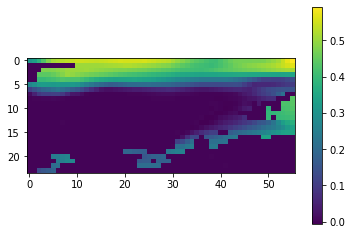

In [17]:
plt.imshow(pred[0,:].reshape(sic_xr.latitude.size, sic_xr.longitude.size).data.numpy())
plt.colorbar()

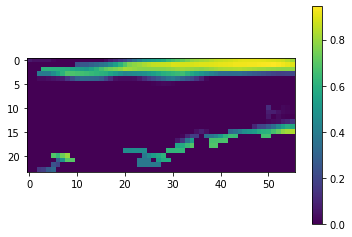

In [18]:
plt.imshow(sic_seq[timestep_test+1,:,:]) # plus one because model predicts one timestep ahead
plt.colorbar()